In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = False)

Mounted at /content/drive


In [44]:
# lib imports
import torch
import os
import numpy as np
import pandas as pd
import random
import cv2

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [45]:
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 3
IMG_COUNT = 480

# Only TS-1

In [57]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torchvision.transforms.functional as TF

import numpy as np
import os
import math
import random
import logging
import logging.handlers
from matplotlib import pyplot as plt



def save_imgs(img, msk, msk_pred, i, save_path, datasets, threshold=0.5, test_data_name=None):
    img = img.squeeze(0).permute(1,2,0).detach().cpu().numpy()
    img = img / 255. if img.max() > 1.1 else img
    if datasets == 'retinal':
        msk = np.squeeze(msk, axis=0)
        msk_pred = np.squeeze(msk_pred, axis=0)
    else:
        msk = np.where(np.squeeze(msk, axis=0) > 0.5, 1, 0)
        msk_pred = np.where(np.squeeze(msk_pred, axis=0) > threshold, 1, 0)

    plt.figure(figsize=(7,15))

    plt.subplot(3,1,1)
    plt.imshow(img)
    plt.axis('off')

    plt.subplot(3,1,2)
    plt.imshow(msk, cmap= 'gray')
    plt.axis('off')

    plt.subplot(3,1,3)
    plt.imshow(msk_pred, cmap = 'gray')
    plt.axis('off')

    if test_data_name is not None:
        save_path = save_path + test_data_name + '_'
    plt.savefig(save_path + str(i) +'.png')
    plt.close()




class myToTensor:
    def __init__(self):
        pass
    def __call__(self, data):
        image, mask = data
        return torch.tensor(image, dtype=torch.float).permute(2,0,1), torch.tensor(mask, dtype=torch.float).permute(2,0,1)


class myResize:
    def __init__(self, size_h=256, size_w=256):
        self.size_h = size_h
        self.size_w = size_w
    def __call__(self, data):
        image, mask = data
        return TF.resize(image, [self.size_h, self.size_w]), TF.resize(mask, [self.size_h, self.size_w])


class myRandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.hflip(image), TF.hflip(mask)
        else: return image, mask


class myRandomVerticalFlip:
    def __init__(self, p=0.5):
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.vflip(image), TF.vflip(mask)
        else: return image, mask


class myRandomRotation:
    def __init__(self, p=0.5, degree=[0,360]):
        self.angle = random.uniform(degree[0], degree[1])
        self.p = p
    def __call__(self, data):
        image, mask = data
        if random.random() < self.p: return TF.rotate(image,self.angle), TF.rotate(mask,self.angle)
        else: return image, mask


class myNormalize:
    def __init__(self, data_name, train=True):
        if data_name == 'GRAIN DATA SET':
            if train:
                self.mean = 157.561
                self.std = 26.706
            else:
                self.mean = 149.034
                self.std = 32.022
        elif data_name == 'isic17':
            if train:
                self.mean = 159.922
                self.std = 28.871
            else:
                self.mean = 148.429
                self.std = 25.748
        elif data_name == 'isic18_82':
            if train:
                self.mean = 156.2899
                self.std = 26.5457
            else:
                self.mean = 149.8485
                self.std = 35.3346
        elif data_name == 'polyp':
            if train:
                self.mean = 86.17
                self.std = 69.08
            else:
                self.mean = 86.17
                self.std = 69.08
        elif data_name == 'gim':
            if train:
                self.mean = 87.84
                self.std = 55.37
            else:
                self.mean = 85.27
                self.std = 54.75
        elif data_name == 'isic_all':
            if train:
                self.mean = 158.6
                self.std = 44.92
            else:
                self.mean = 156.2899
                self.std = 26.5457

    def __call__(self, data):
        img, msk = data
        img_normalized = (img-self.mean)/self.std
        img_normalized = ((img_normalized - np.min(img_normalized))
                            / (np.max(img_normalized)-np.min(img_normalized))) * 255.
        return img_normalized, msk



In [61]:
datasets = 'GRAIN DATA SET'
input_size_h = 256
input_size_w = 256
input_channels = 3

In [60]:
from torchvision import transforms
train_transformer = transforms.Compose([
    myNormalize(datasets, train=True),
    myToTensor(),
    # myRandomHorizontalFlip(p=0.5),
    # myRandomVerticalFlip(p=0.5),
    # myRandomRotation(p=0.5, degree=[0, 360]),
    myResize(input_size_h, input_size_w)
])
test_transformer = transforms.Compose([
    myNormalize(datasets, train=False),
    myToTensor(),
    myResize(input_size_h, input_size_w)
])

In [62]:
from PIL import Image
from torch.utils.data import Dataset

image_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RG'
mask_dir = '/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET/RGMask'

class Polyp_datasets(Dataset):
    def __init__(self, path_Data, train=True):
        super(Polyp_datasets, self)
        if train:
            images_list = sorted(os.listdir(image_dir))
            masks_list = sorted(os.listdir(mask_dir))
            self.data = []
            for i in range(len(images_list)):
                img_path = path_Data+'/RG/' + images_list[i]
                mask_path = path_Data+'/RGMask/' + masks_list[i]
                self.data.append([img_path, mask_path])
            self.transformer = train_transformer
        else:
            images_list = sorted(os.listdir(path_Data+'TestDataset/' + test_dataset + '/images/'))
            masks_list = sorted(os.listdir(path_Data+'TestDataset/' + test_dataset + '/masks/'))
            self.data = []
            for i in range(len(images_list)):
                img_path = path_Data+'TestDataset/' + test_dataset + '/images/' + images_list[i]
                mask_path = path_Data+'TestDataset/' + test_dataset + '/masks/' + masks_list[i]
                self.data.append([img_path, mask_path])
            self.transformer = test_transformer

    def __getitem__(self, index):
        img_path, msk_path = self.data[index]
        img = np.array(Image.open(img_path).convert('RGB'))
        msk = np.expand_dims(np.array(Image.open(msk_path).convert('L')), axis=2) / 255
        img, msk = self.transformer((img, msk))
        return img, msk

    def __len__(self):
        return len(self.data)

dataset = Polyp_datasets('/content/drive/MyDrive/465 Project/ArtificialDataset/GRAIN DATA SET', train=True)


# Example Image and it's Ground Truth

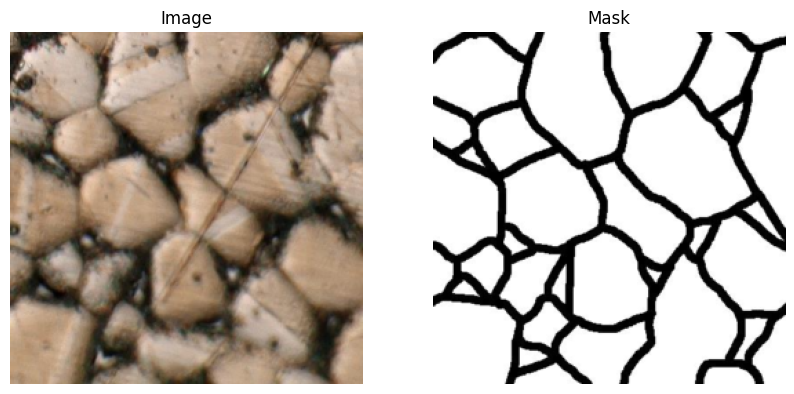

In [63]:
import matplotlib.pyplot as plt

# Assuming train_transformer and test_transformer are defined appropriately

# Get a single data sample
index = 10  # You can change this index to visualize different samples
sample_img, sample_mask = dataset[index]

# Convert sample_img and sample_mask from PyTorch tensors to numpy arrays
sample_img = sample_img.numpy().transpose((1, 2, 0))  # (C, H, W) to (H, W, C)
sample_img = sample_img.astype(float)  # Convert to float for normalization
sample_img /= 255.0  # Normalize to range [0, 1]

sample_mask = sample_mask.squeeze().numpy()  # Remove singleton dimension

# Display the image and mask
plt.figure(figsize=(10, 5))

# Display the image
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title('Image')
plt.axis('off')

# Display the mask
plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap='gray')
plt.title('Mask')
plt.axis('off')

plt.show()

# dataset splitting

In [65]:
import torch
from torch.utils.data import random_split

# Set random seed for reproducibility
torch.manual_seed(20)

# Split the dataset into train and validation sets (80-10-10)
train_size = int(0.80 * len(dataset))
r = len(dataset) - train_size
val_size = int(0.5 * r)
test_size = int(0.5 * r)

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [36]:
from torch.utils.data import random_split, DataLoader

batch_size = 1


train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

Device Agnostic code

# Unet Attention

In [38]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()
        # Contraction path
        self.conv1 = self.contracting_block(in_channels, 16)
        self.conv2 = self.contracting_block(16, 32)
        self.conv3 = self.contracting_block(32, 64)
        self.conv4 = self.contracting_block(64, 128)
        self.conv5 = self.contracting_block(128, 256)


        # Expansive path
        self.upconv6 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv6 = self.expansive_block(256, 128)
        self.upconv7 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv7 = self.expansive_block(128, 64)
        self.upconv8 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv8 = self.expansive_block(64, 32)
        self.upconv9 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)
        self.conv9 = self.expansive_block(32, 16)

        # Output layer
        self.output_conv = nn.Conv2d(16, out_channels, kernel_size=1)

    def contracting_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1),
        )

    def expansive_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Dropout(0.1)
        )

    def forward(self, x):
        # Contraction path
        mx_pool = nn.MaxPool2d(kernel_size=2)
        c1 = self.conv1(x)
        p1 = mx_pool(c1)
        c2 = self.conv2(p1)
        p2 = mx_pool(c2)
        c3 = self.conv3(p2)
        p3 = mx_pool(c3)
        c4 = self.conv4(p3)
        p4 = mx_pool(c4)
        c5 = self.conv5(p4)

        # Expansive path
        u6 = self.upconv6(c5)
        # print(c5.shape)
        # print(u6.shape, c4.shape) # for debugging
        u6 = torch.cat([u6, c4], dim=1)
        c6 = self.conv6(u6)
        u7 = self.upconv7(c6)
        u7 = torch.cat([u7, c3], dim=1)
        c7 = self.conv7(u7)
        u8 = self.upconv8(c7)
        u8 = torch.cat([u8, c2], dim=1)
        c8 = self.conv8(u8)
        u9 = self.upconv9(c8)
        u9 = torch.cat([u9, c1], dim=1)
        c9 = self.conv9(u9)

        # Output layer
        outputs = self.output_conv(c9)
        return torch.sigmoid(outputs)


# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(3, 1).to(device)

# Model summary
from torchsummary import summary
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 256, 256]             448
              ReLU-2         [-1, 16, 256, 256]               0
            Conv2d-3         [-1, 16, 256, 256]           2,320
              ReLU-4         [-1, 16, 256, 256]               0
           Dropout-5         [-1, 16, 256, 256]               0
            Conv2d-6         [-1, 32, 128, 128]           4,640
              ReLU-7         [-1, 32, 128, 128]               0
            Conv2d-8         [-1, 32, 128, 128]           9,248
              ReLU-9         [-1, 32, 128, 128]               0
          Dropout-10         [-1, 32, 128, 128]               0
           Conv2d-11           [-1, 64, 64, 64]          18,496
             ReLU-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,928
             ReLU-14           [-1, 64,

In [43]:
import torch.optim as optim
from torch.utils.data import DataLoader

# Define optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

# Define callbacks
class ModelCheckpoint:
    def __init__(self, checkpoint_path):
        self.checkpoint_path = checkpoint_path
        self.best_loss = float('inf')

    def __call__(self, model, epoch, train_loss, val_loss):
        if val_loss < self.best_loss:
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'train_loss' : train_loss,
            'val_loss': val_loss,
            }, self.checkpoint_path)
            print("Checkpoint saved")
            self.best_loss = val_loss

from datetime import datetime
checkpoint_path = f'/content/drive/MyDrive/465 Project/Unet Checkpoints/Unet-_{datetime.now().strftime("%d%m%Y %H:%M:%S")}.pt'
# print(checkpoint_path)
# os.makedirs("/content/drive/MyDrive/465 Project", exist_ok=True) # already exists
checkpoint_dir = os.path.dirname(checkpoint_path)

checkpointer = ModelCheckpoint(checkpoint_path)

# Assuming 'model' is already transferred to the appropriate device
# and 'device' is defined as 'cuda' if available, otherwise 'cpu'
num_epochs = 20
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    train_loss = 0.0

    for inputs, targets in train_dataloader:
        # Move inputs and targets to the same device as the model
        # inputs = inputs.to(device)
        # targets = targets.to(device)

        optimizer.zero_grad()  # Clear the gradients
        outputs = model(inputs)  # Forward pass: compute the model output
        loss = criterion(outputs, targets)  # Compute loss
        loss.backward()  # Backward pass: compute gradient of the loss with respect to model parameters
        optimizer.step()  # Update parameters
        train_loss += loss.item() * inputs.size(0)  # Aggregate the loss

    # After training batches, compute the average loss
    train_loss /= len(train_dataloader.dataset)

    # Evaluate the model if necessary, make sure to move evaluation data to the same device
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Turn off gradients for validation
        val_loss = 0.0
        for inputs, targets in val_dataloader:
            # inputs = inputs.to(device)
            # targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
        val_loss /= len(val_dataloader.dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    # Call the ModelCheckpoint callback
    # checkpointer(model,epoch, train_loss, val_loss)


RuntimeError: Input type (torch.FloatTensor) and weight type (torch.cuda.FloatTensor) should be the same or input should be a MKLDNN tensor and weight is a dense tensor

In [ ]:
# current_checkpoint = torch.load(checkpoint_path)
# model.load_state_dict(current_checkpoint['model_state_dict'])
# model.eval()
# print(current_checkpoint['train_loss'],current_checkpoint['val_loss'])

## Display Result

In [ ]:
def display_results(image, ground_truth_mask, predicted_mask):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Display input image
    axes[0].imshow(np.transpose(image, (1, 2, 0)))
    axes[0].set_title('Input Image')

    # Display ground truth mask
    axes[1].imshow(np.squeeze(ground_truth_mask))
    axes[1].set_title('Ground Truth Mask')

    # Display predicted mask
    axes[2].imshow(np.squeeze(predicted_mask))
    axes[2].set_title('Predicted Mask')

    plt.show()

# Scores

In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 11.2 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

## test set initialization

# Results

In [ ]:
rg_val_loader = val_dataloader

from torchmetrics.functional import dice
from torchmetrics.functional import jaccard_index

total_jaccard_score = 0.0
total_dice_score = 0.0
total_num_samples = 0

for images, masks in rg_val_loader:
    batch_size = images.size(0)  # Get the actual batch size
    total_num_samples += batch_size

    with torch.no_grad():
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        preds = model(images)

        for ind in range(len(preds)):
            pred_tensor = (preds[ind] > 0.5).float()
            gt_tensor = masks[ind].to(torch.int64)  # Convert mask tensor to integer tensor

            dice_score = dice(pred_tensor, gt_tensor)
            total_dice_score += dice_score.item()

            jaccard_score = jaccard_index(pred_tensor, gt_tensor, task='binary')
            total_jaccard_score += jaccard_score.item()

average_dice_score = total_dice_score / total_num_samples
average_jaccard_score = total_jaccard_score / total_num_samples

print(f"Training set: {TRAINING_SET}")
print(f"Total Number samples: {total_num_samples}")
print(f"Average Dice Score: {average_dice_score}")
print(f"Average Jaccard Index: {average_jaccard_score}")

Training set: 1
Total Number samples: 48
Average Dice Score: 0.9066883474588394
Average Jaccard Index: 0.8296895511448383
